In [2]:
# Scientific libraries
import numpy as np
import os

from threeML import *
from threeML.io.package_data import get_path_of_data_dir
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

%matplotlib inline
plt.style.use("mike")
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)



import warnings

warnings.simplefilter("ignore")

file_dir = os.path.join(get_path_of_data_dir(), "datasets", "multi_analysis")

## Data setup
We are going to use data from Fermi-LAT, Fermi-GBM and Swift-XRT. Let's go through the process of setting up the data from each instrument. We will work from high energy to low energy.


### Fermi-LAT
Once we have obtained the Fermi-LAT data, in this case, the LAT Low Energy (LLE) data, we can reduce the data into an plugin using the light curve tools provided in 3ML. LLE data is in the format of FITS event files with an associated spacecraft point history file and energy dispersion response. The **TimeSeriesBuilder** class has special methods for dealing with the LLE data.


Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method




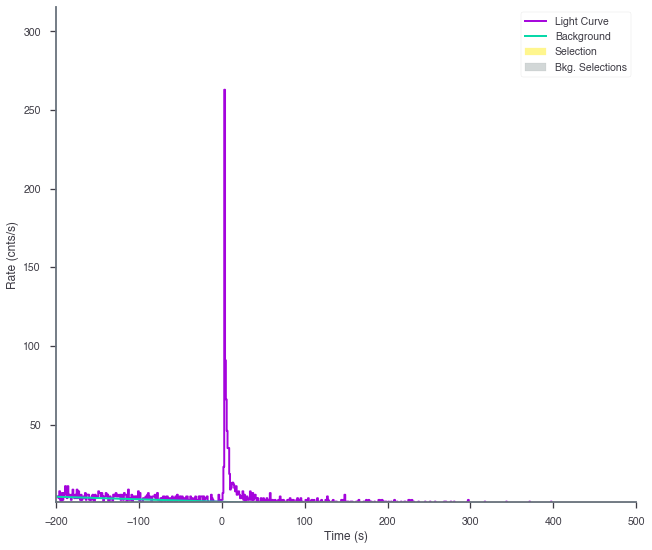

In [3]:
lle = TimeSeriesBuilder.from_lat_lle(
    "lle",
    ft2_file=os.path.join(file_dir, "lle_pt.fit"),
    lle_file=os.path.join(file_dir, "lle.fit"),
    rsp_file=os.path.join(file_dir, "lle.rsp"),
)
lle.set_background_interval("-100--10", "150-500")

lle.set_active_time_interval("68-110")
lle.view_lightcurve(-200, 500);

In [4]:
lle_plugin = lle.to_spectrumlike()
lle_plugin.use_effective_area_correction()

lle_plugin.display()

Auto-probed noise models:
- observation: poisson
- background: gaussian


,0
n. channels,50
total rate,1.47587
total bkg. rate,0.490761
total bkg. rate error,0.0342392
bkg. exposure,38.6214
bkg. is poisson,False
exposure,38.6214
is poisson,True
background,profiled
significance,6.61832


bad channels shown in red hatching



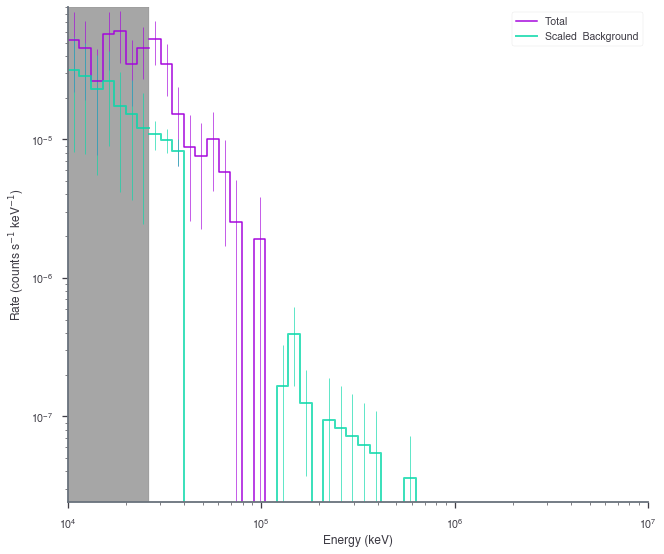

In [5]:
lle_plugin.view_count_spectrum();

### Fermi-GBM

In [6]:
gbm_detectors = ["n4", "n7", "n8", "b0"]

for det in gbm_detectors:
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det,
        cspec_or_ctime_file=os.path.join(file_dir, f"cspec_{det}.pha"),
        rsp_file=os.path.join(file_dir, f"cspec_{det}.rsp2"),
    )

    ts_cspec.set_background_interval("-400--10", "700-1200")

    ts_cspec.save_background(filename=f"{det}_bkg.h5", overwrite=True)

Auto-determined polynomial order: 2




Binned 2-order polynomial fit with the Powell method



Saved fitted background to n4_bkg.h5.



Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method



Saved fitted background to n7_bkg.h5.



Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method



Saved fitted background to n8_bkg.h5.



Auto-determined polynomial order: 4




Binned 4-order polynomial fit with the Powell method



Saved fitted background to b0_bkg.h5.



Successfully restored fit from n4_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian
Successfully restored fit from n7_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian
Successfully restored fit from n8_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian
Successfully restored fit from b0_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian


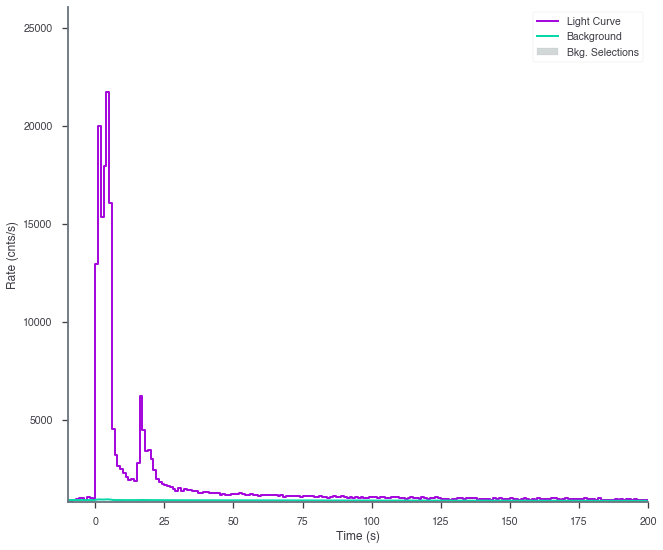

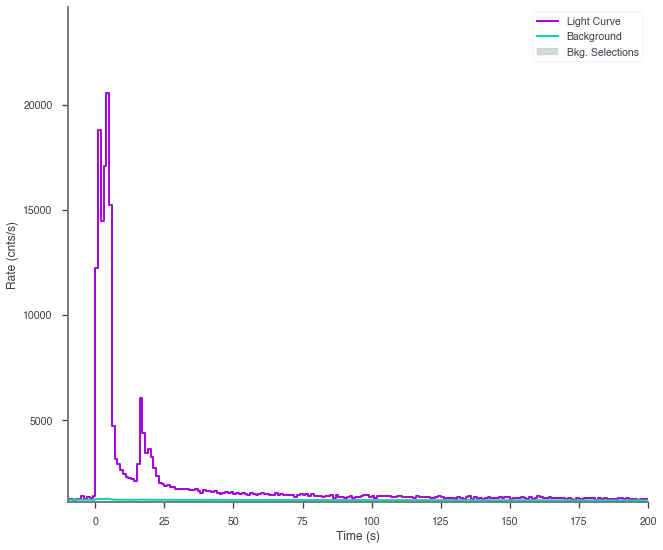

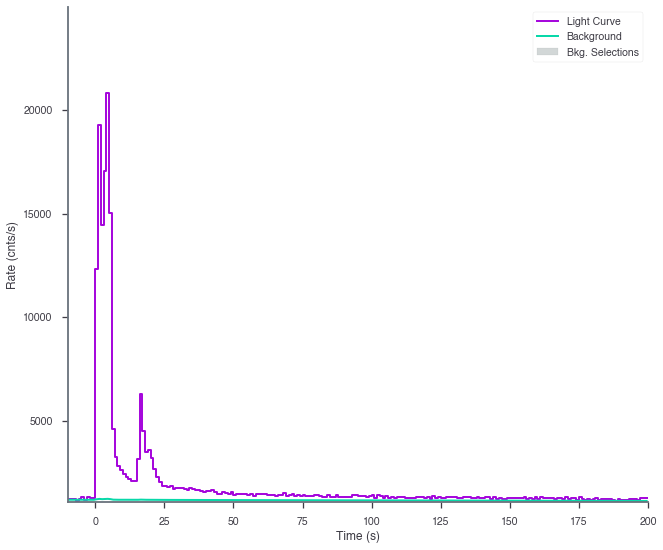

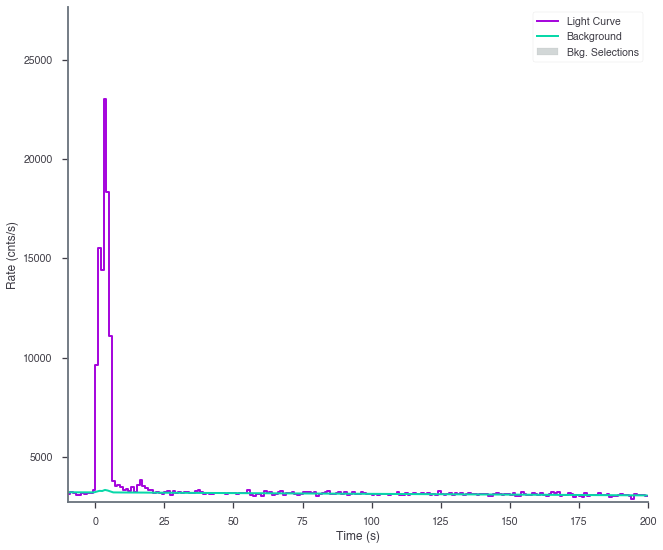

In [7]:
gbm_time_series = {}
gbm_plugins = {}
for det in gbm_detectors:


    ts = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=os.path.join(file_dir,f"tte_{det}.fit.gz"),
        rsp_file=os.path.join(file_dir,f"cspec_{det}.rsp2"),
        restore_background=f"{det}_bkg.h5",
    )

    gbm_time_series[det] = ts

    ts.view_lightcurve(-10, 200)
    ts.set_active_time_interval("68-110")
    gbm_plugins[det] = ts.to_spectrumlike()

Range 10-900 translates to channels 6-123
Now using 118 channels out of 128
Now using 118 bins
Range 10-900 translates to channels 6-122
Now using 117 channels out of 128
Now using 117 bins
Range 10-900 translates to channels 5-124
Now using 120 channels out of 128
Now using 120 bins
Range 250-30000 translates to channels 1-119
Now using 119 channels out of 128
Now using 119 bins


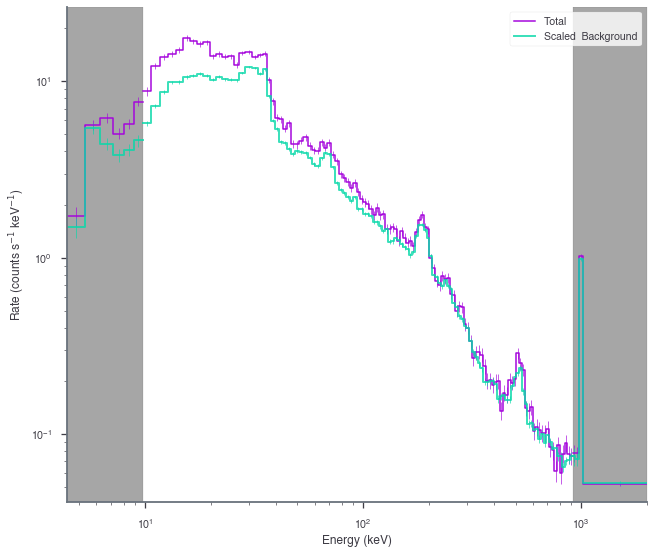

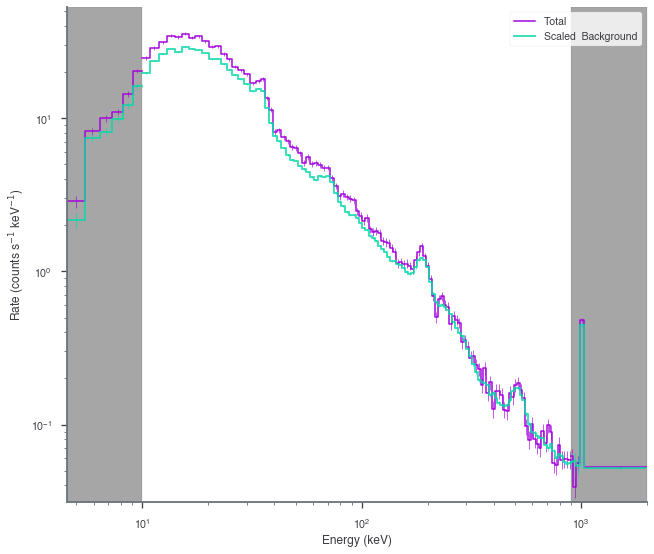

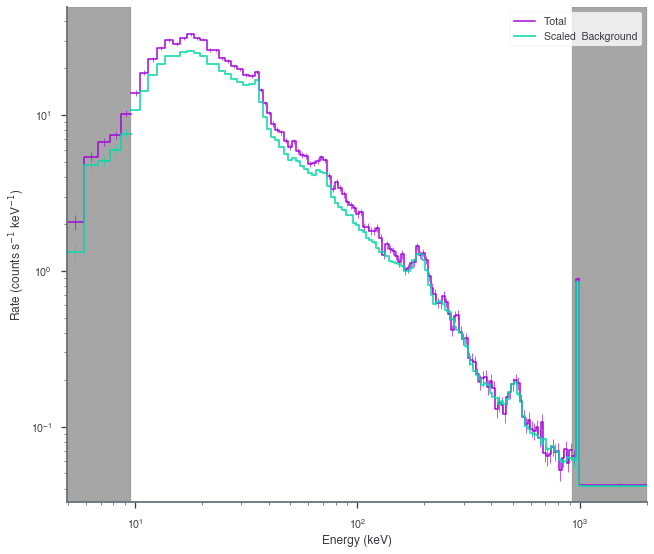

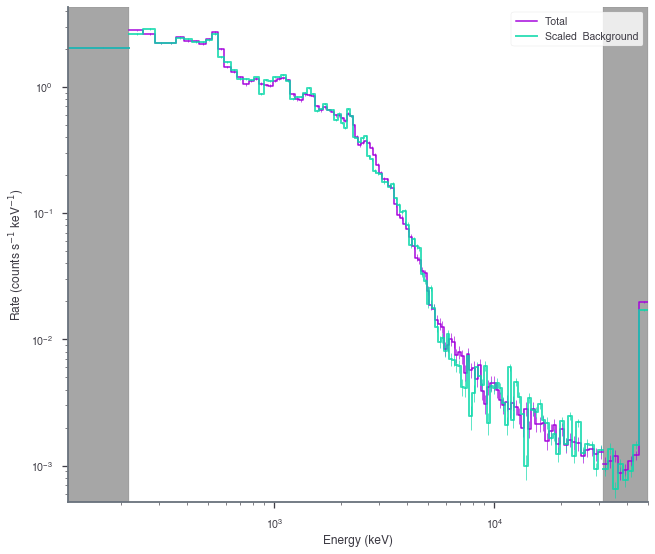

In [8]:
for det, plugin in gbm_plugins.items():

    if det.startswith("b"):

        plugin.set_active_measurements("250-30000")

    else:

        plugin.set_active_measurements("10-900")
        
    if det != "n3":
        
        plugin.use_effective_area_correction()

    plugin.rebin_on_background(1)
    plugin.view_count_spectrum()

### Swift-XRT

For Swift-XRT, we can use the normal **OGIPLike** plugin, but the energy resolution of the instrument is so fine that we would waste time integrating over the photon bins during forward-folding. Thus, there is a special plugin that overrides the computation of the photon integrals with a simple sum. 


In [9]:
xrt = SwiftXRTLike(
    "xrt",
    observation=os.path.join(file_dir,"awt.pi"),
    background=os.path.join(file_dir,"awtback.pi"),
    arf_file=os.path.join(file_dir,"awt.arf"),
    response=os.path.join(file_dir,"awt.rmf"),
)
xrt.display()

Auto-probed noise models:
- observation: poisson
- background: poisson


,0
pha file,/Users/jburgess/coding/tml/threeml/threeML/dat...
bak file,/Users/jburgess/coding/tml/threeml/threeML/dat...
n. channels,1024
total rate,83.186
total bkg. rate,14.1426
bkg. exposure,41.9301
bkg. is poisson,True
exposure,41.9301
is poisson,True
background,profiled


Range 4-10 translates to channels 399-999
Now using 601 channels out of 1024
Now using 126 bins
bad channels shown in red hatching



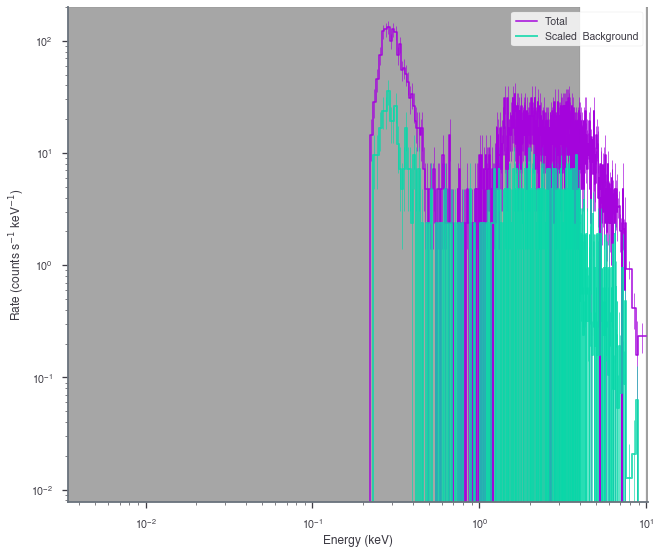

In [11]:
xrt.remove_rebinning()
xrt.set_active_measurements("4-10")

xrt.rebin_on_background(1.0)
xrt.use_effective_area_correction()
xrt.view_count_spectrum();

### Combining all the plugins

In [12]:
all_plugins = [lle_plugin, xrt]
for _, plugin in gbm_plugins.items():

    all_plugins.append(plugin)


datalist = DataList(*all_plugins)

## Fitting

### Model setup

#### Band Function

In [14]:
sbpl = SmoothlyBrokenPowerLaw(pivot=1E3)

sbpl.alpha.prior =  Truncated_gaussian(lower_bound=-1.5, upper_bound=0, mu=-1, sigma=1.)
sbpl.beta.prior =  Truncated_gaussian(lower_bound=-3., upper_bound=-1.6, mu=-2, sigma=1.)
sbpl.break_energy.prior = Log_normal(mu=np.log(20), sigma=np.log(20))
sbpl.break_scale.prior =  Log_uniform_prior(lower_bound=1E-3, upper_bound=1.)
sbpl.K.prior = Log_uniform_prior(lower_bound=1E-2, upper_bound=1E2)
sbpl.K = 1E-1
sbpl.break_scale.free=True
sbpl.break_energy.bounds = (0, None)



# band = Band()

# band.alpha.prior =  Truncated_gaussian(lower_bound=-1.5, upper_bound=0, mu=-1, sigma=.5)
# band.beta.prior =  Truncated_gaussian(lower_bound=-3., upper_bound=-1.6, mu=-2, sigma=.5)
# band.xp.prior = Log_normal(mu=np.log(50), sigma=np.log(50))
# band.K.prior = Log_uniform_prior(lower_bound=1E-5, upper_bound=1E1)
# band.xp=10
# band.K=1E-1


# band.xp.bounds = (0, None)


ps = PointSource('grb',0,0,spectral_shape=sbpl)

model = Model(ps)

In [15]:
bayes = BayesianAnalysis(model,datalist)
bayes.set_sampler('multinest')

In [16]:
for k,v in model.free_parameters.items():
    if "cons" in k:
        
        v.prior = Truncated_gaussian(lower_bound=.8, upper_bound=1.2, mu=1, sigma=.1)
        
    

In [ ]:

#bayes.sampler.setup(dlogz=10.,frac_remain=.5)
bayes.sampler.setup(n_live_points=1000)

bayes.sample()


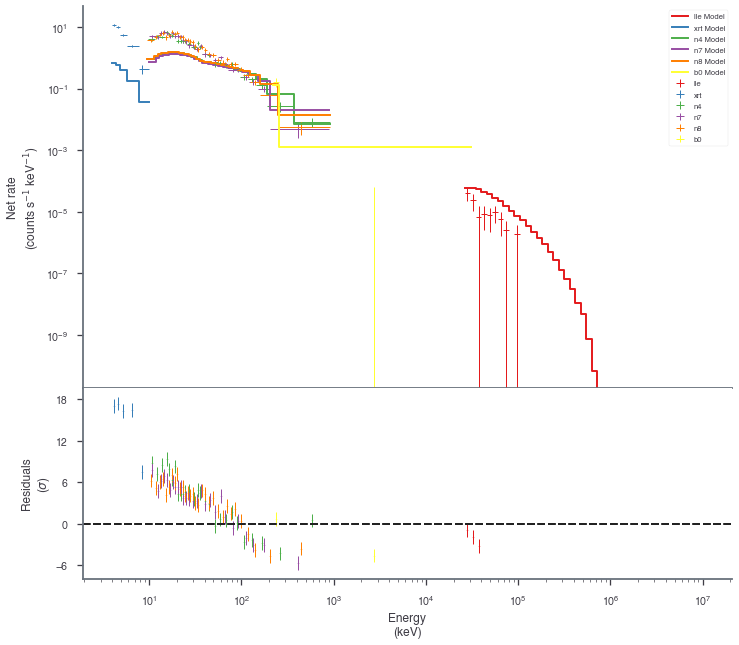

In [53]:
#bayes.restore_median_fit()
sbpl.K = 1E-4
sbpl.break_energy = 50.
display_spectrum_model_counts(bayes, min_rate=[-1,5,5,5,5,5]);

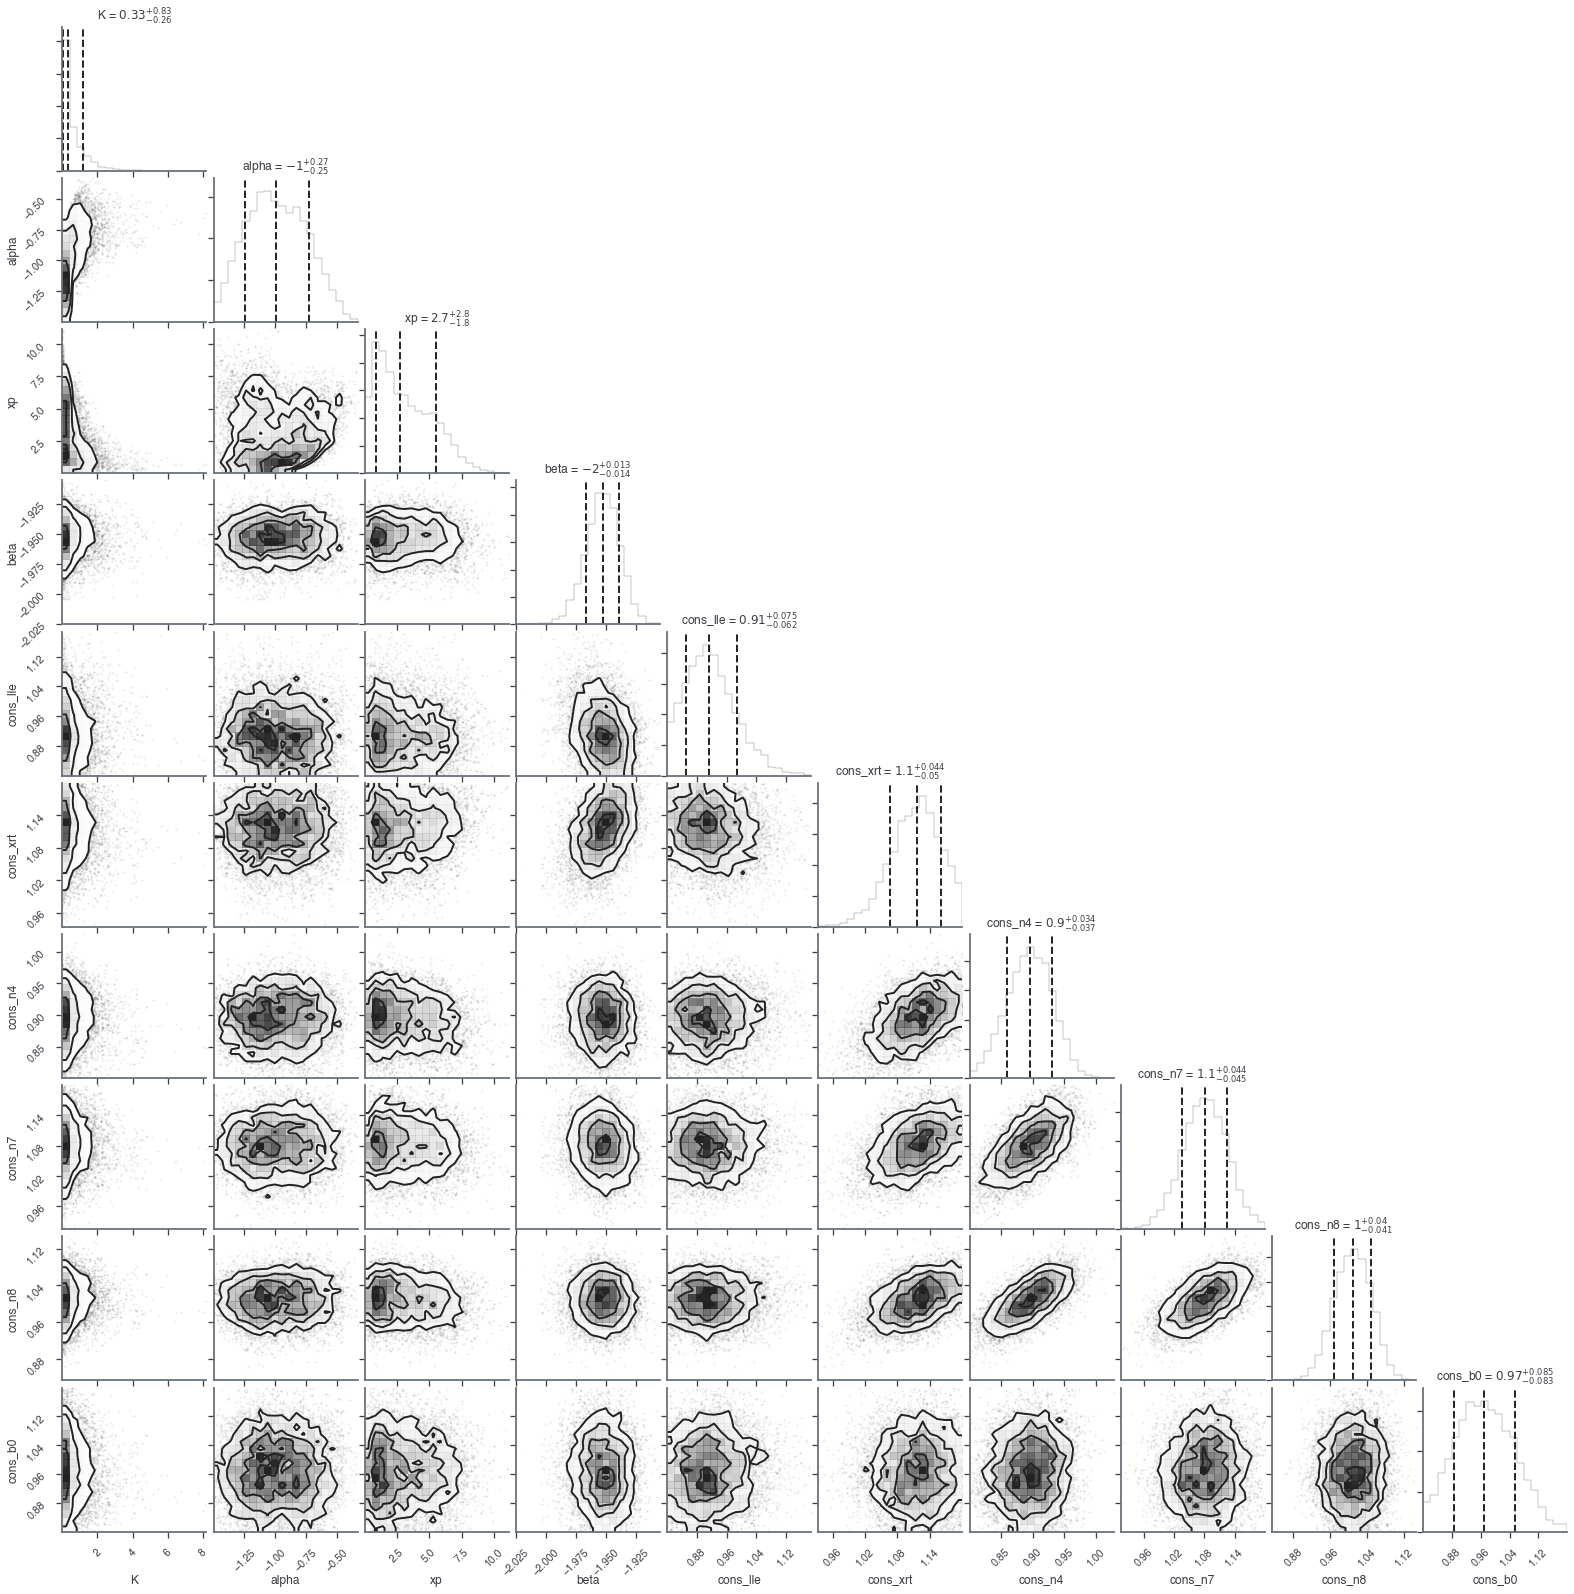

In [35]:
bayes.results.corner_plot();

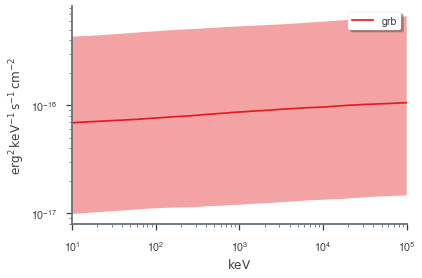

In [36]:
plot_spectra(bayes.results, flux_unit='erg2/(cm2 s keV)',ene_max =1E5);